In [285]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [286]:
eps = 0.01

path = "./ORL3232/"
folders = sorted(os.listdir(path)[:-1], key = lambda x : int(x))

imgs = []
labels = []

for folder in folders:
    p = path + folder + '/'
    files = os.listdir(p)
    files = [p+x for x in files if x.endswith(".bmp")]
    for file in files:
        img = cv2.imread(file, 0) / 255.0
        #img = img.reshape([-1])
        imgs.append(np.reshape(img, [32, 32, 1]))
        labels.append(int(folder) - 1)

print("done")

done


In [287]:
x_data = imgs.copy() * 2
y_data = labels.copy() * 2

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1207)

x_train = tf.constant(x_train, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
y_train = tf.one_hot(y_train, len(folders))
y_test = tf.one_hot(y_test, len(folders))

assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]

In [288]:
class Model(keras.models.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pool = keras.layers.MaxPool2D()
        self.flat = keras.layers.Flatten()
        self.conv1 = keras.layers.Conv2D(32, 3, activation=tf.nn.relu)
        self.conv2 = keras.layers.Conv2D(24, 3, activation=tf.nn.relu)
        self.conv3 = keras.layers.Conv2D(16, 3, activation=tf.nn.relu)
        self.layer1 = keras.layers.Dense(128, activation=tf.nn.relu)
        self.layer2 = keras.layers.Dense(64, activation=tf.nn.relu)
        self.layer3 = keras.layers.Dense(40, activation=tf.nn.softmax)
        
    def call(self, input):
        x = input
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.flat(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [289]:
model = Model()
model.compile(keras.optimizers.Adam(), tf.losses.categorical_crossentropy, tf.metrics.categorical_accuracy)

history = model.fit(x_train, y_train, batch_size=8, epochs=50, validation_split=0.2)

Epoch 1/50
64/64 [==============================] - 1s 7ms/step - loss: 3.6926 - categorical_accuracy: 0.0273 - val_loss: 3.6915 - val_categorical_accuracy: 0.0156
Epoch 2/50
64/64 [==============================] - 0s 5ms/step - loss: 3.6892 - categorical_accuracy: 0.0254 - val_loss: 3.6950 - val_categorical_accuracy: 0.0000e+00
Epoch 3/50
64/64 [==============================] - 0s 5ms/step - loss: 3.6863 - categorical_accuracy: 0.0254 - val_loss: 3.7074 - val_categorical_accuracy: 0.0000e+00
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: 3.6867 - categorical_accuracy: 0.0332 - val_loss: 3.6954 - val_categorical_accuracy: 0.0000e+00
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 3.6791 - categorical_accuracy: 0.0352 - val_loss: 3.7024 - val_categorical_accuracy: 0.0000e+00
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 3.6651 - categorical_accuracy: 0.0293 - val_loss: 3.6821 - val_categorical_accuracy: 0.0078


In [290]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.9907 - categorical_accuracy: 0.9563


[0.9906856417655945, 0.956250011920929]

FGSM

In [291]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

Adversarial Training

In [292]:
def generate_adv(img, label, model, epsilon = eps):
    img = tf.expand_dims(tf.constant(img, dtype=tf.float32), 0)
    label = tf.expand_dims(tf.one_hot(label, len(folders)), 0)
    perturbations = create_adversarial_pattern(img, label, model)
    return img + epsilon*perturbations

In [293]:
img_adv = [imgs[i] + generate_adv(imgs[i], labels[i], model)[0].numpy() for i in range(len(imgs))]

x_data_adv = imgs.copy()
x_data_adv.extend(img_adv)
y_data_adv = labels.copy()
y_data_adv.extend(labels.copy())

x_train_adv, x_test_adv, y_train_adv, y_test_adv = train_test_split(x_data_adv, y_data_adv, test_size=0.2, random_state=1207)

x_train_adv = tf.constant(x_train_adv, dtype=tf.float32)
x_test_adv = tf.constant(x_test_adv, dtype=tf.float32)
y_train_adv = tf.one_hot(y_train_adv, len(folders))
y_test_adv = tf.one_hot(y_test_adv, len(folders))

assert x_train_adv.shape[0] == y_train_adv.shape[0]
assert x_test_adv.shape[0] == y_test_adv.shape[0]


In [294]:
model_adv = Model()
model_adv.compile(keras.optimizers.Adam(), tf.losses.categorical_crossentropy, tf.metrics.categorical_accuracy)

history_adv = model_adv.fit(x_train_adv, y_train_adv, batch_size=8, epochs=50, validation_split=0.2)

Epoch 1/50
64/64 [==============================] - 2s 9ms/step - loss: 3.6931 - categorical_accuracy: 0.0215 - val_loss: 3.6933 - val_categorical_accuracy: 0.0156
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 3.6879 - categorical_accuracy: 0.0312 - val_loss: 3.6943 - val_categorical_accuracy: 0.0156
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 3.6832 - categorical_accuracy: 0.0410 - val_loss: 3.7039 - val_categorical_accuracy: 0.0156
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 3.6778 - categorical_accuracy: 0.0410 - val_loss: 3.6893 - val_categorical_accuracy: 0.0156
Epoch 5/50
64/64 [==============================] - 1s 9ms/step - loss: 3.6354 - categorical_accuracy: 0.0469 - val_loss: 3.6190 - val_categorical_accuracy: 0.0156
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 3.3203 - categorical_accuracy: 0.1074 - val_loss: 3.3299 - val_categorical_accuracy: 0.0859
Epoch 7/50
64/64

In [295]:
model_adv.evaluate(x_test, y_test)

5/5 [==============================] - 0s 6ms/step - loss: 0.3917 - categorical_accuracy: 0.9500


[0.39169734716415405, 0.949999988079071]

Compare

In [296]:
def display_images(image, gt):
    fig, axes = plt.subplots(2, 2)
    epsilons = [0, eps]
    descriptions = ['Epsilon = {:0.3f}'.format(eps) for eps in epsilons]
    perturbations = create_adversarial_pattern(image, gt, model)
    for i in range(2):
        for j in range(2):
            img = image + epsilons[j] * perturbations
            description = "Origin Model, " + descriptions[j] if i == 0 else "Adv Model, " + descriptions[j]
            pred = model.predict(img, verbose=0) if i == 0 else model_adv.predict(img, verbose=0)
            label = tf.argmax(pred, -1)[0]
            confidence = pred[0, label]
            axes[j, i].imshow(cv2.cvtColor(img[0].numpy()*0.5+0.5, cv2.COLOR_BGR2RGB))
            axes[j, i].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

True Label : 36


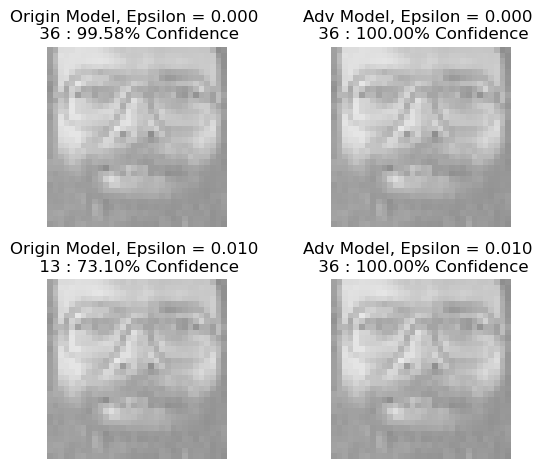

In [297]:
for i in range(x_test.shape[0]):
    image = tf.expand_dims(x_test[i], 0)
    label = tf.expand_dims(y_test[i], 0)
    if(tf.argmax(model.predict(image, verbose=0), -1)[0] == tf.argmax(label, -1)[0]):
        perturbations = create_adversarial_pattern(image, label, model)
        adv_x = image + eps*perturbations
        if(tf.argmax(model.predict(image, verbose=0), -1)[0] != tf.argmax(model.predict(adv_x, verbose=0), -1)[0]):
            if(tf.argmax(model_adv.predict(image, verbose=0), -1)[0] == tf.argmax(model_adv.predict(adv_x, verbose=0), -1)[0]):
                print("True Label : {}".format(tf.argmax(label, -1)[0].numpy()))
                break

display_images(image, label)

In [298]:
model.evaluate(x_test_adv, y_test_adv)
model_adv.evaluate(x_test_adv, y_test_adv)

5/5 [==============================] - 0s 5ms/step - loss: 0.5617 - categorical_accuracy: 0.9375


[0.5616599917411804, 0.9375]